# Moon dataset - Semi_supervised classification

Xuekai Li

2025_april


In [1]:
# Standard libraries
import time
from collections import Counter, defaultdict, deque

# Third-party libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from imblearn.over_sampling import SMOTE

# PyTorch for deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# scikit-learn utilities
from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.datasets import fetch_20newsgroups, make_moons
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

### 📘 Data Generation and Visualization

In this step, we generate a synthetic dataset using the `make_moons` function from `scikit-learn`. This dataset is commonly used for testing classification and clustering algorithms, as it presents a non-linearly separable structure that is ideal for demonstrating the effectiveness of machine learning models.

- **Dataset**: 2,000 samples shaped like two interleaving half circles (moons)
- **Noise**: Gaussian noise (`noise=0.3`) is added to make the classification task more challenging
- **Visualization**:
  - A scatter plot displays the two classes using color coding
  - The X and Y axes represent the two features
  - A grid and clean layout are applied for better readability

This dataset will serve as the input for subsequent preprocessing, training, and evaluation steps in the notebook.


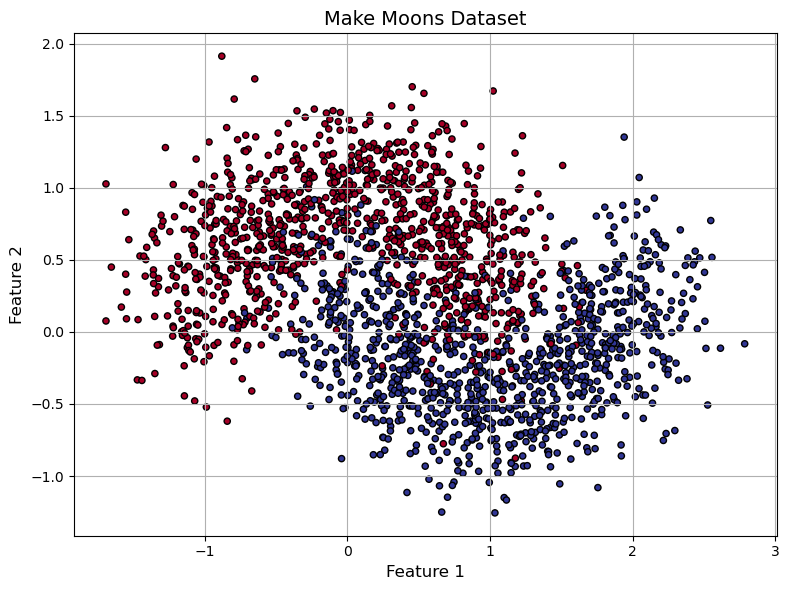

In [2]:
# Generate synthetic two-moons dataset
X, y = make_moons(n_samples=2000, noise=0.3, random_state=42)

# Plot the dataset
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu, edgecolor='k', s=20)
plt.title("Make Moons Dataset", fontsize=14)
plt.xlabel("Feature 1", fontsize=12)
plt.ylabel("Feature 2", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


### 🧪 Data Preparation and Balancing

This section performs preprocessing and balancing on the synthetic "moons" dataset:




/var/folders/7f/tnlxqvzd3935f89h0dgn0vbm0000gn/T/ipykernel_75347/3687880064.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, palette="viridis")
/var/folders/7f/tnlxqvzd3935f89h0dgn0vbm0000gn/T/ipykernel_75347/3687880064.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_validation, palette="viridis")
/var/folders/7f/tnlxqvzd3935f89h0dgn0vbm0000gn/T/ipykernel_75347/3687880064.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_test, palette="viridis")


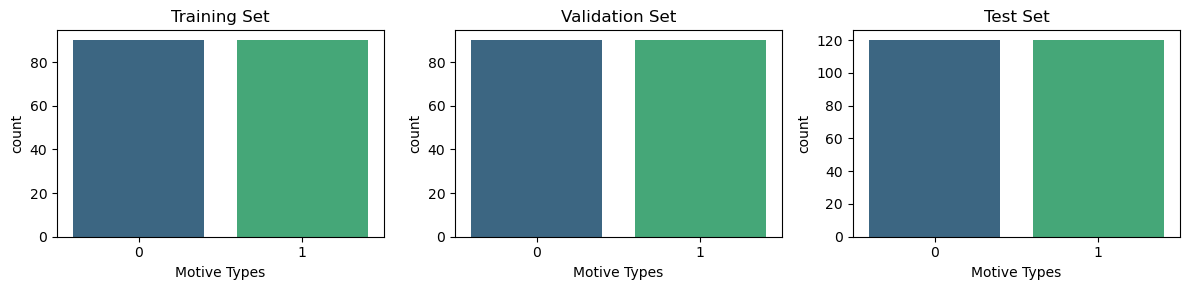

/var/folders/7f/tnlxqvzd3935f89h0dgn0vbm0000gn/T/ipykernel_75347/3687880064.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_resampled, palette="viridis")


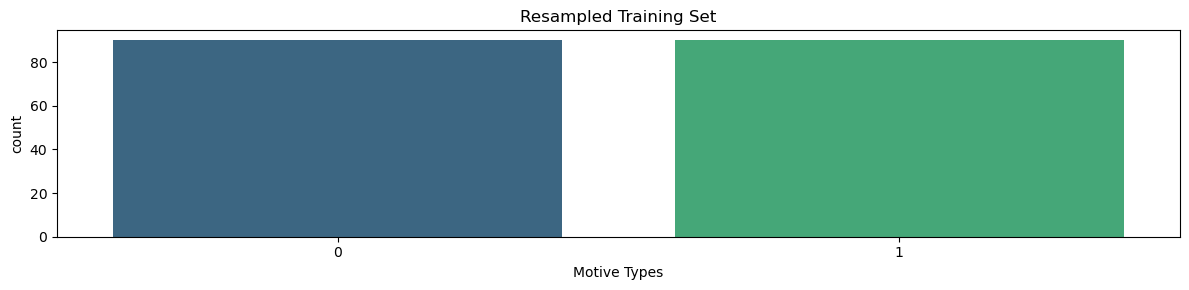

In [3]:
# Normalize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the labeled and unlabeled data
X_ul, X_l, y_ul, y_l = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Further split labeled data into training, validation, and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_l, y_l, test_size=0.4, stratify=y_l, random_state=42
)

X_train, X_validation, y_train, y_validation = train_test_split(
    X_train_full, y_train_full, test_size=0.5, stratify=y_train_full, random_state=42
)

# Plot class distribution in training, validation, and test sets
plt.figure(figsize=(12, 3))

plt.subplot(131)
sns.countplot(x=y_train, palette="viridis")
plt.title("Training Set")
plt.xlabel("Motive Types")

plt.subplot(132)
sns.countplot(x=y_validation, palette="viridis")
plt.title("Validation Set")
plt.xlabel("Motive Types")

plt.subplot(133)
sns.countplot(x=y_test, palette="viridis")
plt.title("Test Set")
plt.xlabel("Motive Types")

plt.tight_layout()
plt.show()

# Apply SMOTE to the training set
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Plot distribution of resampled training data
plt.figure(figsize=(12, 3))
sns.countplot(x=y_resampled, palette="viridis")
plt.title("Resampled Training Set")
plt.xlabel("Motive Types")
plt.tight_layout()
plt.show()


In [4]:
# Print dataset sizes
print(f"Training set:    {X_train.shape[0]} samples")
print(f"Validation set:  {X_validation.shape[0]} samples")
print(f"Unlabeled set:   {X_ul.shape[0]} samples")
print(f"Test set:        {X_test.shape[0]} samples")


Training set:    180 samples
Validation set:  180 samples
Unlabeled set:   1400 samples
Test set:        240 samples


### 🤖 Classifier Initialization

Two machine learning classifiers are initialized for use in training and co-training:

- **K-Nearest Neighbors (KNN)**:
  - Uses cosine distance to compare samples
  - Uniform weighting for neighbors
  - Configured with 10 neighbors

- **Support Vector Machine (SVM)**:
  - Radial Basis Function (RBF) kernel
  - Outputs probability estimates (`probability=True`)
  - Higher iteration limit for convergence on complex datasets

These models will be trained and evaluated individually or together in a co-training framework.


In [5]:
# Initialize classifiers: K-Nearest Neighbors and Support Vector Machine
clf_knn = KNeighborsClassifier(
    n_neighbors=10,
    metric='cosine',
    weights='uniform'
)

clf_svm = SVC(
    kernel='rbf',
    probability=True,
    tol=1e-4,
    max_iter=10000,
    C=1.0
)

# Store classifiers in a list for co-training or evaluation
classifiers = [clf_knn, clf_svm]


### 🔁 Co-Training with KNN and SVM

In this section, we apply a co-training approach using two classifiers — **KNN** and **SVM** — to improve performance on a semi-supervised dataset.


In [6]:
# Train initial classifiers on resampled labeled data
clf_knn.fit(X_resampled, y_resampled)
clf_svm.fit(X_resampled, y_resampled)

# Evaluate on training set
print(f"KNN F1 (train): {f1_score(y_resampled, clf_knn.predict(X_resampled), average='macro'):.4f}")
print(f"SVM F1 (train): {f1_score(y_resampled, clf_svm.predict(X_resampled), average='macro'):.4f}")

# Evaluate on test set
f1_knn = f1_score(y_test, clf_knn.predict(X_test), average='macro')
f1_svm = f1_score(y_test, clf_svm.predict(X_test), average='macro')
f1_micro_knn = f1_score(y_test, clf_knn.predict(X_test), average='micro')
f1_micro_svm = f1_score(y_test, clf_svm.predict(X_test), average='micro')

# Co-training setup
X_cotrain = X_ul.copy()

# Dynamic confidence threshold based on validation performance
confidence_threshold = (
    f1_score(y_validation, clf_knn.predict(X_validation), average='macro') +
    f1_score(y_validation, clf_svm.predict(X_validation), average='macro')
) / 2.0

# Get predictions and confidence scores
proba_knn = clf_knn.predict_proba(X_cotrain)
confidence_knn = np.max(proba_knn, axis=1)
labels_knn = np.argmax(proba_knn, axis=1)

proba_svm = clf_svm.predict_proba(X_cotrain)
confidence_svm = np.max(proba_svm, axis=1)
labels_svm = np.argmax(proba_svm, axis=1)

# Select high-confidence samples
high_conf_knn = confidence_knn >= np.percentile(confidence_knn, confidence_threshold * 100)
high_conf_svm = confidence_svm > np.percentile(confidence_svm, confidence_threshold * 100)

# Get indices and pseudo-labels
knn_indices = np.where(high_conf_knn)[0]
svm_indices = np.where(high_conf_svm)[0]
print(f"High-confidence: KNN={len(knn_indices)}, SVM={len(svm_indices)}")

X_knn_add, y_knn_add = X_cotrain[svm_indices], labels_svm[svm_indices]
X_svm_add, y_svm_add = X_cotrain[knn_indices], labels_knn[knn_indices]

# Augment training sets with pseudo-labeled data
X_labeled_knn = np.vstack([X_resampled, X_knn_add])
y_labeled_knn = np.hstack([y_resampled, y_knn_add])

X_labeled_svm = np.vstack([X_resampled, X_svm_add])
y_labeled_svm = np.hstack([y_resampled, y_svm_add])

# Retrain classifiers
clf_knn.fit(X_labeled_knn, y_labeled_knn)
clf_svm.fit(X_labeled_svm, y_labeled_svm)

# Compute classifier weights based on validation set
classifier_weights = np.array([
    f1_score(y_validation, clf.predict(X_validation), average='weighted')
    for clf in [clf_knn, clf_svm]
])
classifier_weights += 1e-6  # Avoid division by zero
classifier_weights /= classifier_weights.sum()
print("Classifier Weights:", classifier_weights)

# Combine predictions using weighted probabilities
combined_probabilities = np.average(
    [clf.predict_proba(X_test) for clf in [clf_knn, clf_svm]],
    axis=0,
    weights=classifier_weights
)
combined_predictions = np.argmax(combined_probabilities, axis=1)

# Final evaluation
co_f1_macro = f1_score(y_test, combined_predictions, average='macro')
co_f1_micro = f1_score(y_test, combined_predictions, average='micro')

# Post co-training classifier scores
f1_knn_co = f1_score(y_test, clf_knn.predict(X_test), average='macro')
f1_svm_co = f1_score(y_test, clf_svm.predict(X_test), average='macro')
f1_micro_knn_co = f1_score(y_test, clf_knn.predict(X_test), average='micro')
f1_micro_svm_co = f1_score(y_test, clf_svm.predict(X_test), average='micro')

# Print all results
print(f"Before Co-training - KNN Macro F1:  {f1_knn:.4f}")
print(f"After  Co-training - KNN Macro F1:  {f1_knn_co:.4f}")
print("-" * 40)
print(f"Before Co-training - SVM Macro F1:  {f1_svm:.4f}")
print(f"After  Co-training - SVM Macro F1:  {f1_svm_co:.4f}")
print("-" * 40)
print(f"Before Co-training - KNN Micro F1:  {f1_micro_knn:.4f}")
print(f"After  Co-training - KNN Micro F1:  {f1_micro_knn_co:.4f}")
print("-" * 40)
print(f"Before Co-training - SVM Micro F1:  {f1_micro_svm:.4f}")
print(f"After  Co-training - SVM Micro F1:  {f1_micro_svm_co:.4f}")
print("-" * 40)
print(f"Final Combined F1 Macro: {co_f1_macro:.4f}")
print(f"Final Combined F1 Micro: {co_f1_micro:.4f}")


KNN F1 (train): 0.8833
SVM F1 (train): 0.9055
High-confidence: KNN=330, SVM=183
Classifier Weights: [0.48726071 0.51273929]
Before Co-training - KNN Macro F1:  0.8833
After  Co-training - KNN Macro F1:  0.8833
----------------------------------------
Before Co-training - SVM Macro F1:  0.8958
After  Co-training - SVM Macro F1:  0.8999
----------------------------------------
Before Co-training - KNN Micro F1:  0.8833
After  Co-training - KNN Micro F1:  0.8833
----------------------------------------
Before Co-training - SVM Micro F1:  0.8958
After  Co-training - SVM Micro F1:  0.9000
----------------------------------------
Final Combined F1 Macro: 0.9041
Final Combined F1 Micro: 0.9042


### 🧩 `Env` Class: Reinforcement Learning Environment for Co-Training

This custom `Env` class wraps a co-training environment for reinforcement learning. It manages data partitioning, classifier updates, state construction, and reward computation for a policy learning agent.

#### Key Features:
- **Clustering unlabeled data** using agglomerative clustering to define discrete "actions"
- **State representation**: Based on softmax probability distributions over cluster centroids from both classifiers
- **Reward signal**: Based on the F1 score improvement, normalized by a rolling average baseline
- **Co-training**:
  - Each model pseudo-labels samples the other can learn from
  - Only high-confidence predictions (above a dynamic threshold) are selected

This environment can be used with policy gradient methods (like Actor-Critic) to learn intelligent sample selection strategies for semi-supervised learning tasks.


In [7]:
class Env:
    def __init__(self, classifiers, input_ul_data, k, X_test, y_test, X_reset, y_reset, window_size=10):
        self.models = classifiers
        self.X_ul = input_ul_data
        self.X_eval = X_test
        self.y_eval = y_test
        self.X_reset = X_reset
        self.y_reset = y_reset
        self.action_size = k
        self.window_size = window_size

        # Cluster unlabeled data
        self.agglo = AgglomerativeClustering(n_clusters=k, linkage='ward')
        self.cluster_label = self.agglo.fit_predict(self.X_ul)
        self.u_cluster_label = np.unique(self.cluster_label)

        # Compute cluster centroids
        self.centroids = np.array([
            self.X_ul[self.cluster_label == i].mean(axis=0)
            for i in self.u_cluster_label
        ])

        self.observation_size = self.get_state(reset=True).shape[1]
        self.prev_macro_f1 = 0.0
        self.f1_diff_history = deque(maxlen=window_size)

    def train_2_clf(self, X, y):
        for model in self.models:
            model.fit(X, y)

    def get_state(self, reset=False):
        if reset:
            if self.X_reset is None or self.y_reset is None:
                raise ValueError("Reset datasets X_reset or y_reset are not provided.")
            self.train_2_clf(self.X_reset, self.y_reset)

        try:
            out_1 = self.models[0].predict_proba(self.centroids)
            out_2 = self.models[1].predict_proba(self.centroids)
        except Exception as e:
            raise RuntimeError(f"Model prediction failed: {e}")

        state_proba = np.concatenate((out_1, out_2), axis=1)
        return torch.from_numpy(state_proba).float().reshape(1, -1)

    def get_f1(self, X_eval=None, y_eval=None):
        X_eval = X_eval if X_eval is not None else self.X_eval
        y_eval = y_eval if y_eval is not None else self.y_eval

        classifier_weights = np.array([
            f1_score(y_eval, clf.predict(X_eval), average='weighted')
            for clf in self.models
        ])
        classifier_weights += 1e-6  # Avoid zero division
        classifier_weights /= classifier_weights.sum()

        combined_probs = np.average(
            [clf.predict_proba(X_eval) for clf in self.models],
            axis=0,
            weights=classifier_weights
        )
        combined_preds = np.argmax(combined_probs, axis=1)

        return (
            f1_score(y_eval, combined_preds, average='macro'),
            f1_score(y_eval, combined_preds, average='micro'),
            f1_score(y_eval, combined_preds, average='weighted'),
        )

    def get_subset(self, action):
        return self.X_ul[self.cluster_label == action]

    def co_training(self, subset):
        confidence_threshold = (
            f1_score(self.y_eval, self.models[0].predict(self.X_eval), average='macro') +
            f1_score(self.y_eval, self.models[1].predict(self.X_eval), average='macro')
        ) / 2.0

        proba_knn = self.models[0].predict_proba(subset)
        proba_svm = self.models[1].predict_proba(subset)

        confidence_knn = np.max(proba_knn, axis=1)
        labels_knn = np.argmax(proba_knn, axis=1)

        confidence_svm = np.max(proba_svm, axis=1)
        labels_svm = np.argmax(proba_svm, axis=1)

        high_conf_knn = confidence_knn > np.percentile(confidence_knn, confidence_threshold * 100)
        high_conf_svm = confidence_svm > np.percentile(confidence_svm, confidence_threshold * 100)

        knn_indices = np.where(high_conf_knn)[0]
        svm_indices = np.where(high_conf_svm)[0]

        X_knn_add, y_knn_add = subset[svm_indices], labels_svm[svm_indices]
        X_svm_add, y_svm_add = subset[knn_indices], labels_knn[knn_indices]

        X_labeled_knn = np.vstack([self.X_reset, X_knn_add])
        y_labeled_knn = np.hstack([self.y_reset, y_knn_add])

        X_labeled_svm = np.vstack([self.X_reset, X_svm_add])
        y_labeled_svm = np.hstack([self.y_reset, y_svm_add])

        self.models[0].fit(X_labeled_knn, y_labeled_knn)
        self.models[1].fit(X_labeled_svm, y_labeled_svm)

        return self.get_f1()

    def step(self, action):
        macro_f1_before, _, _ = self.get_f1()

        subset = self.get_subset(action)
        macro_f1_after, micro_f1_after, weighted_f1_after = self.co_training(subset)

        next_state = self.get_state()

        f1_diff = macro_f1_after - macro_f1_before
        self.f1_diff_history.append(f1_diff)
        baseline = np.mean(self.f1_diff_history) if self.f1_diff_history else f1_diff
        reward = f1_diff - baseline

        return next_state, reward, macro_f1_after, micro_f1_after, weighted_f1_after


### ⚙️ Environment Initialization

The `Env` class is instantiated with the following settings:

- **Cluster count** `k = 17`: used to divide unlabeled data into discrete action spaces
- **Unlabeled data**: passed in via `X_ul`
- **Labeled data for reset**: `X_resampled`, `y_resampled`
- **Validation set**: `X_validation`, `y_validation`

Once initialized, the environment:
- Performs clustering
- Computes cluster centroids
- Trains the classifiers on the reset set
- Prepares the state representation for RL input

The `env.get_f1()` call confirms initial performance before training begins.


In [8]:
# Initialize the environment for reinforcement-based co-training
k = 17
env = Env(
    classifiers=classifiers,
    input_ul_data=X_ul,
    k=k,
    X_test=X_validation,
    y_test=y_validation,
    X_reset=X_resampled,
    y_reset=y_resampled
)

# Check initial combined F1 scores on validation set
env.get_f1()

# Optional: retrieve one cluster subset for inspection
# env.get_subset(2)


(0.8777777777777778, 0.8777777777777778, 0.8777777777777778)

### 🧠 Actor-Critic Model Definition

This is the core neural architecture used for reinforcement learning via the **Actor-Critic** method.

#### Structure:
- **Shared hidden layers**:
  - Two fully connected layers with ReLU activations (128 units each)
- **Actor head**:
  - Outputs a softmax distribution over possible actions
- **Critic head**:
  - Predicts the scalar value of the current state (used to calculate advantage)

This network learns to both select actions and estimate value simultaneously — a common setup in policy gradient methods.


In [11]:
# Actor-Critic neural network for reinforcement learning
class ActorCritic(nn.Module):
    def __init__(self, state_size, action_size):
        super(ActorCritic, self).__init__()

        # Shared hidden layers
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)

        # Actor head: outputs action probabilities
        self.actor = nn.Linear(128, action_size)

        # Critic head: outputs state value
        self.critic = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))

        # Actor: softmax distribution over actions
        action_probs = torch.softmax(self.actor(x), dim=-1)

        # Critic: scalar state-value estimate
        state_value = self.critic(x)

        return action_probs, state_value


### ⚙️ Actor-Critic Setup and Training Configuration

This cell initializes the components required for training a reinforcement learning agent with an Actor-Critic architecture.

#### Components:
- **`ActorCritic` model**:
  - Takes in the state size (based on cluster-wise classifier probabilities)
  - Outputs both action probabilities and state-value estimates
- **Optimizer**:
  - Adam optimizer with a learning rate of `0.001`
- **Hyperparameters**:
  - `num_episodes`: Total number of episodes the agent will train
  - `gamma`: Discount factor for future rewards (closer to 1 favors long-term gains)
- **Metric Tracking**:
  - `episode_rewards`: Cumulative reward per episode
  - `episode_f1`: F1 scores at each step (macro)
  - `macro_f1_scores` & `micro_f1_scores`: Final episode F1 tracking for evaluation


In [12]:
# Initialize Actor-Critic network and optimizer
actor_critic = ActorCritic(env.observation_size, env.action_size)
optimizer = optim.Adam(actor_critic.parameters(), lr=0.001)

# Training hyperparameters
num_episodes = 200
gamma = 0.99  # Discount factor for future rewards

# Score tracking lists
episode_rewards = []
episode_f1 = []
macro_f1_scores = []
micro_f1_scores = []


### 🎮 Main Training Loop: Actor-Critic with Co-Training Environment

This is the core reinforcement learning loop, where the `ActorCritic` network interacts with the custom `Env` environment to improve classifier performance.

#### Key Components:
- **Episodes**: The loop runs for a defined number of episodes (`num_episodes`)
- **Steps**: Each episode has a fixed number of steps (max 199)
- **Actor-Critic Inference**:
  - The actor samples an action based on the current state
  - The critic estimates the state's value
- **Environment Response**:
  - Executes the action (selects and co-trains on a cluster)
  - Returns the next state, reward, and evaluation scores
- **Advantage Calculation**:
  - Uses temporal difference:  
    `advantage = reward + γ * V(s') - V(s)`
- **Loss Calculation**:
  - **Actor loss** encourages actions that lead to higher advantage
  - **Critic loss** minimizes prediction error of value estimates
- **Optimization**:
  - Total loss is backpropagated to update both heads of the network

#### Output:
- Periodically logs episode reward
- Stores macro/micro F1 scores for final analysis


In [13]:
# Main training loop for Actor-Critic co-training
for episode in tqdm(range(num_episodes)):
    state = env.get_state(reset=True)
    episode_reward = 0

    for t in range(1, 200):  # Limit episode length
        # Sample action from actor's policy distribution
        action_probs, state_value = actor_critic(state)
        dist = torch.distributions.Categorical(action_probs)
        action = dist.sample()

        # Environment step: take action and receive feedback
        next_state, reward, macro_f1, micro_f1, weighted_f1 = env.step(action.item())
        next_state = torch.FloatTensor(next_state).unsqueeze(0)

        # Compute advantage using critic predictions
        _, next_state_value = actor_critic(next_state)
        advantage = reward + gamma * next_state_value - state_value

        # Calculate actor and critic losses
        actor_loss = -dist.log_prob(action) * advantage.detach()
        critic_loss = advantage.pow(2)
        total_loss = actor_loss + critic_loss

        # Update network parameters
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # Advance to next state
        state = next_state
        episode_reward += reward
        episode_f1.append(macro_f1)

        # Store detailed metrics from last episode
        if episode == num_episodes - 1:
            macro_f1_scores.append(macro_f1)
            micro_f1_scores.append(micro_f1)

    # Track reward per episode
    episode_rewards.append(episode_reward)

    if episode % 10 == 0:
        print(f"Episode {episode}, Reward: {episode_reward:.4f}")


  0%|          | 0/200 [00:00<?, ?it/s]

Episode 0, Reward: 0.0029
Episode 10, Reward: -0.0011
Episode 20, Reward: 0.0033
Episode 30, Reward: 0.0000
Episode 40, Reward: -0.0006
Episode 50, Reward: 0.0045
Episode 60, Reward: -0.0011
Episode 70, Reward: 0.0028
Episode 80, Reward: 0.0067
Episode 90, Reward: -0.0017
Episode 100, Reward: -0.0067
Episode 110, Reward: 0.0017
Episode 120, Reward: 0.0039
Episode 130, Reward: -0.0005
Episode 140, Reward: 0.0111
Episode 150, Reward: -0.0006
Episode 160, Reward: -0.0039
Episode 170, Reward: -0.0005
Episode 180, Reward: -0.0044
Episode 190, Reward: -0.0006


### 🏁 Final Evaluation: RL-Enhanced Co-Training

After completing the reinforcement learning training loop, we evaluate the performance of the co-trained classifiers using the **test set**.

- **Macro-F1 Score**: Measures performance equally across all classes (class-level average)
- **Micro-F1 Score**: Measures overall performance across all samples (sample-level average)

These scores reflect the **combined prediction output** of both classifiers, weighted by their validation performance during inference.

This provides a final benchmark for the impact of RL-guided co-training compared to earlier baselines.


In [14]:
# Evaluate co-training performance after RL-based training
corl_f1_macro, corl_f1_micro, _ = env.get_f1(X_eval=X_test, y_eval=y_test)

# Print final F1 scores for the combined classifier
print(f"RL Co-training Combined F1 Macro: {corl_f1_macro:.4f}")
print(f"RL Co-training Combined F1 Micro: {corl_f1_micro:.4f}")


RL Co-training Combined F1 Macro: 0.8957
RL Co-training Combined F1 Micro: 0.8958


### 📈 Episode Reward Progression

This plot shows the **total reward earned per episode** during reinforcement learning training. It provides a visual indication of:

- **Learning stability**: Smooth upward trends reflect consistent policy improvement
- **Exploration effectiveness**: Plateaus or dips may indicate overfitting or local minima
- **Reward signal quality**: Helps diagnose whether the reward formulation is meaningful

This is a key diagnostic tool when training RL agents.


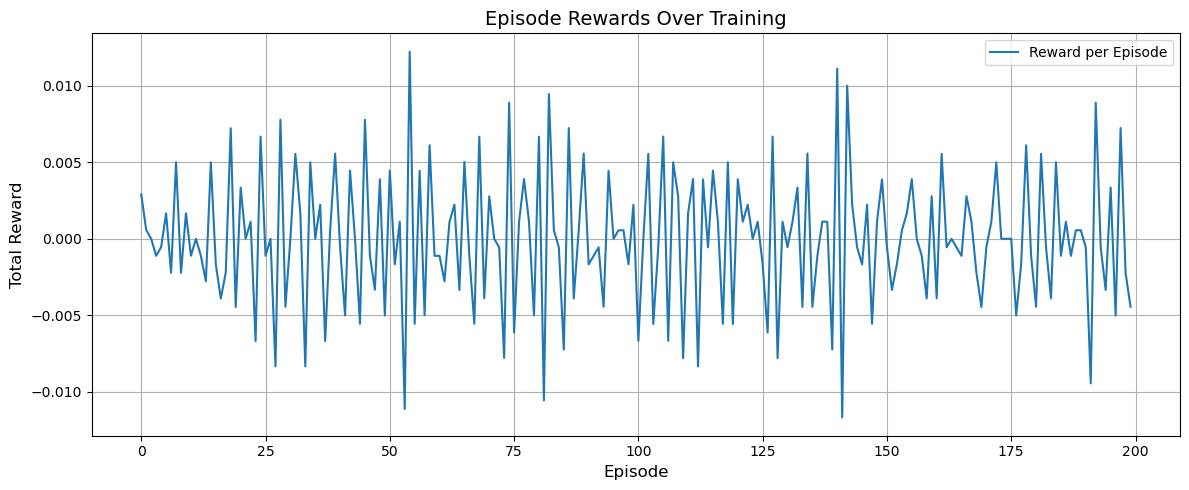

In [15]:
# Plot: Episode reward progression during RL training
plt.figure(figsize=(12, 5))
plt.plot(episode_rewards, label="Reward per Episode")
plt.title("Episode Rewards Over Training", fontsize=14)
plt.xlabel("Episode", fontsize=12)
plt.ylabel("Total Reward", fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### 📊 Average Macro-F1 Score per Episode

This plot tracks the **average Macro-F1 score** achieved during each episode of reinforcement learning training.

- **Macro-F1** accounts for performance across all classes equally
- The per-step scores within each episode are averaged
- This provides a smoother view of how well the model is **improving classification performance** over time

Spikes or drops in this plot can indicate how stable or effective the RL-guided co-training process is.


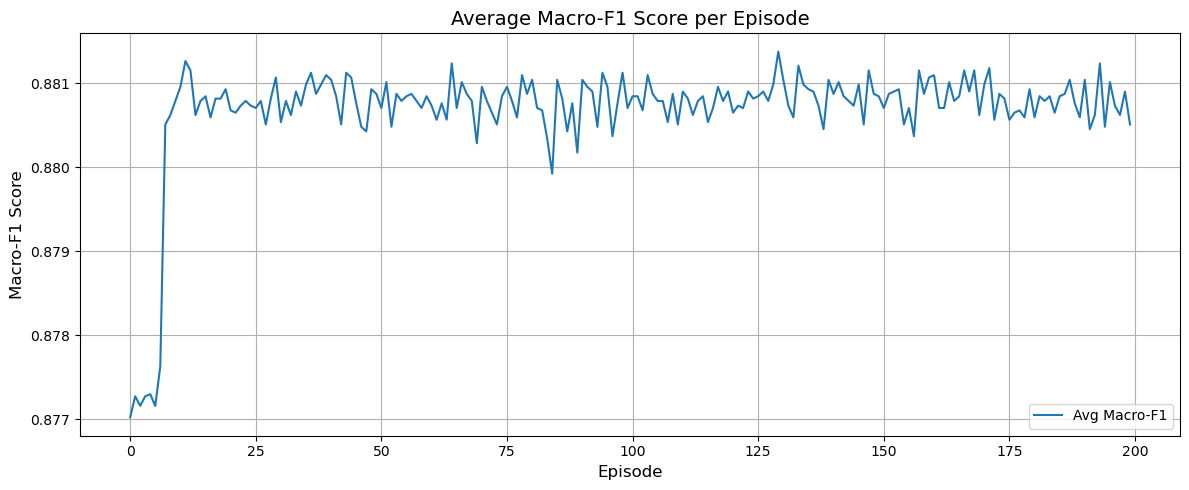

In [16]:
# Plot: Average Macro-F1 Score per Episode
steps_per_episode = 199  # Number of time steps per episode

# Reshape F1 scores into (episodes x steps)
f1_matrix = np.array(episode_f1).reshape(-1, steps_per_episode)

# Compute per-episode average Macro-F1
avg_f1_per_episode = f1_matrix.mean(axis=1)

plt.figure(figsize=(12, 5))
plt.plot(avg_f1_per_episode, label="Avg Macro-F1")
plt.title("Average Macro-F1 Score per Episode", fontsize=14)
plt.xlabel("Episode", fontsize=12)
plt.ylabel("Macro-F1 Score", fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### 📉 Final Episode: Step-by-Step F1 Score Progression

This plot shows how the **Macro-F1** and **Micro-F1** scores evolved at each time step during the **final episode** of reinforcement learning.

- **Macro-F1** emphasizes balanced performance across classes
- **Micro-F1** emphasizes overall instance-level performance

This plot reveals the fine-grained dynamics of classifier improvement within a single episode, and can highlight:
- How stable the learned policy is
- Whether it tends to improve performance consistently as it trains


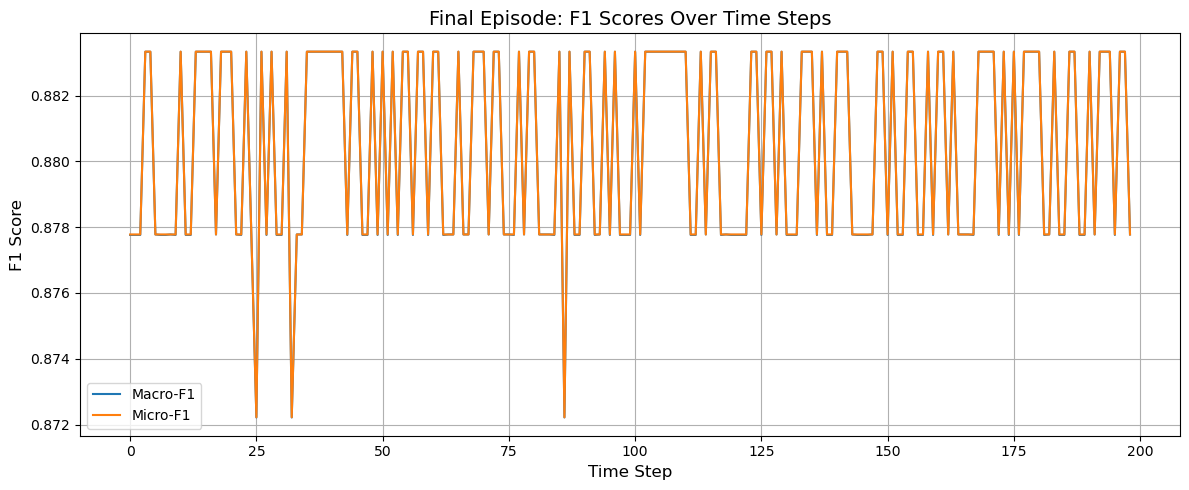

In [17]:
# Plot: Step-by-step F1 scores from the final episode
plt.figure(figsize=(12, 5))
plt.plot(macro_f1_scores, label="Macro-F1")
plt.plot(micro_f1_scores, label="Micro-F1")
plt.title("Final Episode: F1 Scores Over Time Steps", fontsize=14)
plt.xlabel("Time Step", fontsize=12)
plt.ylabel("F1 Score", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
